In [1]:
from utils import TickerDataGenerator, choose_tickers
from os import listdir
from random import sample
from typing import *
import sys
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

from copy import deepcopy


In [2]:
def _is_colab() -> bool:
    return 'google.colab' in sys.modules

def mount_drive():
    if _is_colab():
        from google.colab import drive
        drive.mount("/content/gdrive")


def fit_scaler(scaler: MinMaxScaler, 
               X_train: np.ndarray, 
               y_train: np.ndarray, 
               X_test: list, 
               y_test: list):
    #we want the scaler to handle all sorts of price action, high volatility to low...so fit all together
    data_to_scale = np.concatenate([X_train.flatten(), 
                                    y_train.flatten(), 
                                    np.array(X_test).flatten(), 
                                    np.array(y_test).flatten()]).reshape(-1,1)
    scaler.fit(data_to_scale)

mount_drive()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
PATH = "gdrive/MyDrive/PriceData/PriceData"
TICKER_LIST = choose_tickers(PATH, 20)
FEATURES = ["close", "high", "low"]
LABEL = "close"
SPLIT_PERC = 0.2
PERIOD = 20

data_gen = TickerDataGenerator(TICKER_LIST, PATH)

X_train, y_train, X_test, y_test = data_gen.create_train_data(feature_cols = FEATURES, 
                                                              label_col = LABEL,
                                                              split_perc=SPLIT_PERC,
                                                              period=PERIOD,
                                                              as_pct_change=True, 
                                                              as_cumsum=True)
print(f"""
Num Train samples: {X_train.shape[0]}
Num Test samples: {sum([x.shape[0] for x in X_test])}
""")



Num Train samples: 20720
Num Test samples: 5160



In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
fit_scaler(scaler, X_train, y_train, X_test, y_test)

X_train = np.array([scaler.transform(x) for x in X_train])
y_train = np.array([scaler.transform(y.reshape(-1,1)) for y in y_train])
X_test =  [np.array([scaler.transform(x) for x in ticker]) for ticker in X_test]

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = [torch.from_numpy(x).type(torch.Tensor) for x in X_test]
y_train = torch.from_numpy(y_train).type(torch.Tensor).reshape(-1,1)

In [11]:
INPUT_DIM = X_train.size(-1)
OUTPUT_DIM = y_train.size(-1)
NUM_EPOCHS = 60

In [12]:
X_train.size()

torch.Size([20720, 19, 3])

In [16]:
class PricePredictionGRU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PricePredictionGRU, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = 2
        self.GRU1 = nn.GRU(input_dim, 
                          32, 
                          self.num_layers,
                          batch_first=True)
        
        self.GRU2 = nn.GRU(1, 
                          32, 
                          self.num_layers,
                          batch_first=True)

        self.GRU3 = nn.GRU(32, 
                          32, 
                          self.num_layers,
                          batch_first=True)

        self.dense1 = nn.Linear(32, 8)
        self.dense2 = nn.Linear(8, output_dim)
        
    def __gru_initial_hidden(self, 
                             num_layers: int, 
                             batch_size: int, 
                             num_feats: int) -> torch.Tensor:
        return torch.zeros(num_layers, batch_size, num_feats)


    def __calc_diff(self, 
                    X: torch.Tensor, 
                    binary: bool = True) -> torch.Tensor:
        diff = torch.diff(X[:,:,0])
        diff = torch.cat([torch.zeros(X.size(0)).view(-1,1), diff], 1)
        if binary:
            diff[diff > 0] = 1
            diff[diff < 0] = -1
        return torch.unsqueeze(diff, 2)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        diff_X = self.__calc_diff(X)
        hidden_initial = self.__gru_initial_hidden(self.num_layers, X.size(0), 32).requires_grad_()
        hidden_initial_diff = deepcopy(hidden_initial)

        out_X, out_hidden_X = self.GRU1(X, hidden_initial)
        out_diff, out_hidden_diff = self.GRU2(diff_X, hidden_initial_diff)

        out = (out_X + out_diff) / 2
        out_hidden = (out_hidden_X + out_hidden_diff) / 2

        out, _  = self.GRU3(out, out_hidden)

        out = self.dense2(self.dense1(out[:, -1, :]))
        return out




In [17]:
model = PricePredictionGRU(INPUT_DIM, OUTPUT_DIM)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
def train_model(NUM_EPOCHS):
    hist = np.zeros(NUM_EPOCHS)
    start_time = time.time()
    for e in range(NUM_EPOCHS):
        optimizer.zero_grad()
        yhat = model(X_train)
        loss = criterion(yhat, y_train)
        print(f"Epoch: {e} || MSE: {loss.item()}\n")
        hist[e] = loss.item()
        loss.backward()
        optimizer.step()

    print(f"Total Time Elapsed: {time.time()-start_time}")
    return hist

hist = train_model(60)


Epoch: 0 || MSE: 0.044984377920627594

Epoch: 1 || MSE: 0.08118456602096558

Epoch: 2 || MSE: 0.042672280222177505

Epoch: 3 || MSE: 0.04530865326523781

Epoch: 4 || MSE: 0.045795243233442307

Epoch: 5 || MSE: 0.043000951409339905

Epoch: 6 || MSE: 0.04117965325713158

Epoch: 7 || MSE: 0.04105539992451668

Epoch: 8 || MSE: 0.04027646407485008

Epoch: 9 || MSE: 0.03705578297376633

Epoch: 10 || MSE: 0.031906381249427795

Epoch: 11 || MSE: 0.022389771416783333

Epoch: 12 || MSE: 0.010285579599440098

Epoch: 13 || MSE: 0.011867283843457699

Epoch: 14 || MSE: 0.01297325361520052

Epoch: 15 || MSE: 0.010631147772073746

Epoch: 16 || MSE: 0.0054518659599125385

Epoch: 17 || MSE: 0.009407959878444672

Epoch: 18 || MSE: 0.009626006707549095

Epoch: 19 || MSE: 0.00828627124428749

Epoch: 20 || MSE: 0.006477673538029194

Epoch: 21 || MSE: 0.002980878110975027

Epoch: 22 || MSE: 0.0030082049779593945

Epoch: 23 || MSE: 0.0036632448900491

Epoch: 24 || MSE: 0.005932074971497059

Epoch: 25 || MSE: 

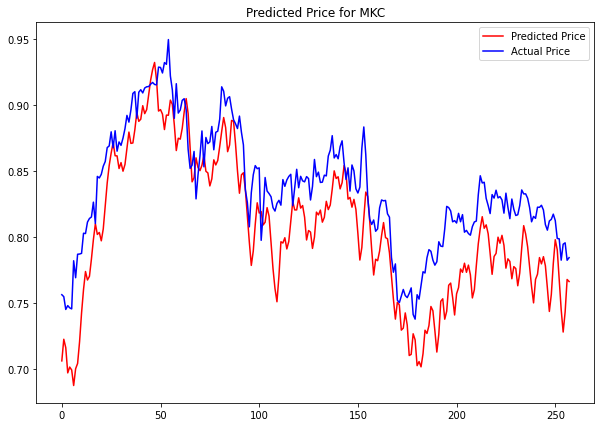

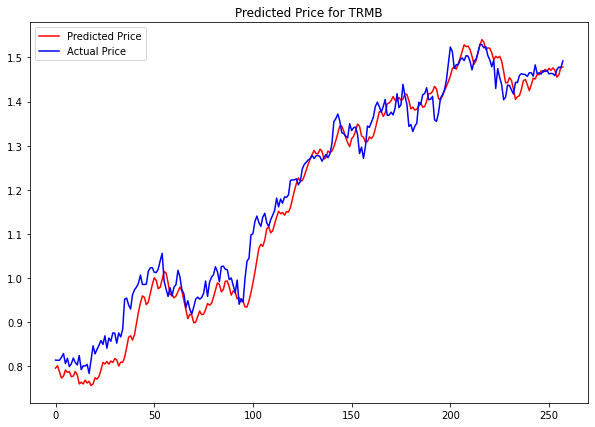

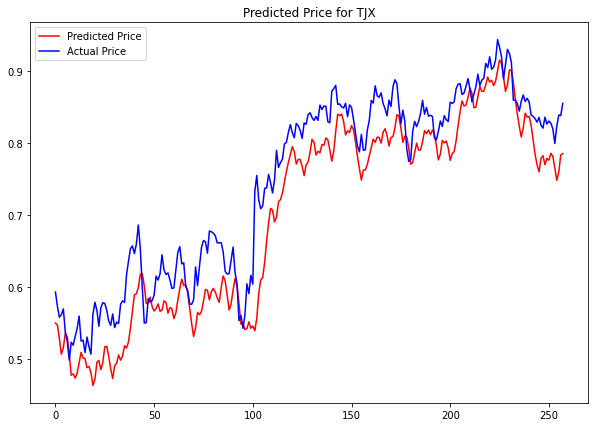

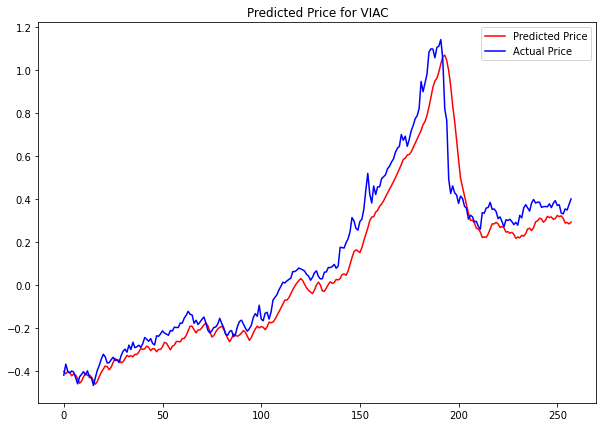

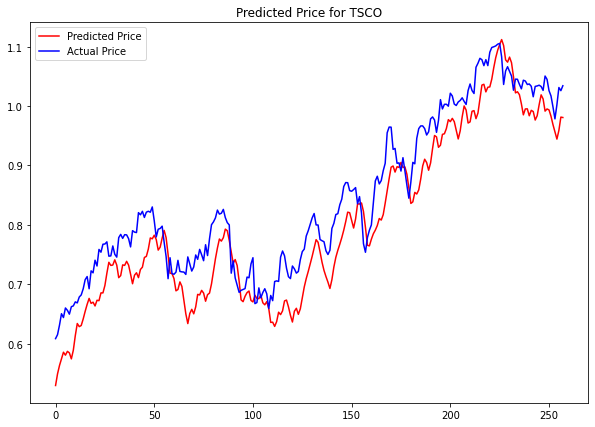

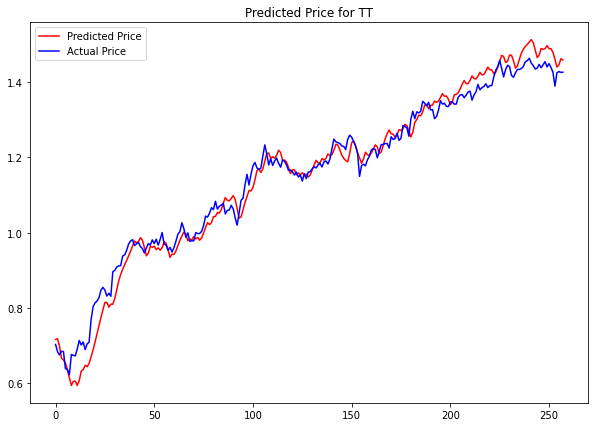

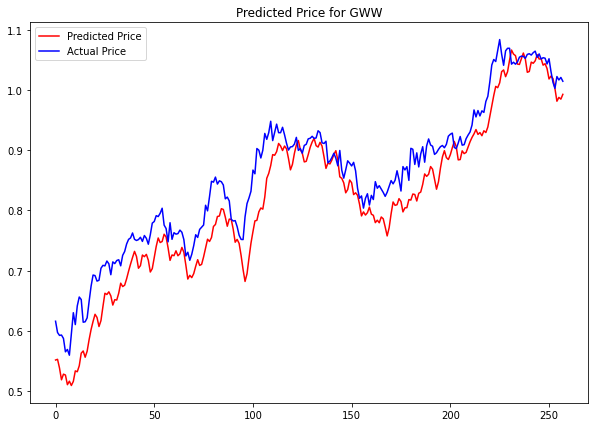

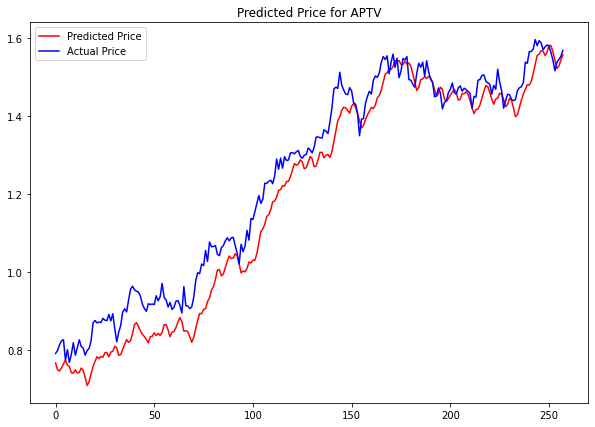

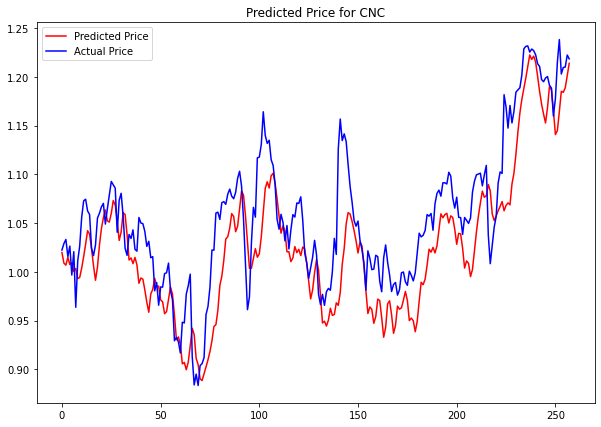

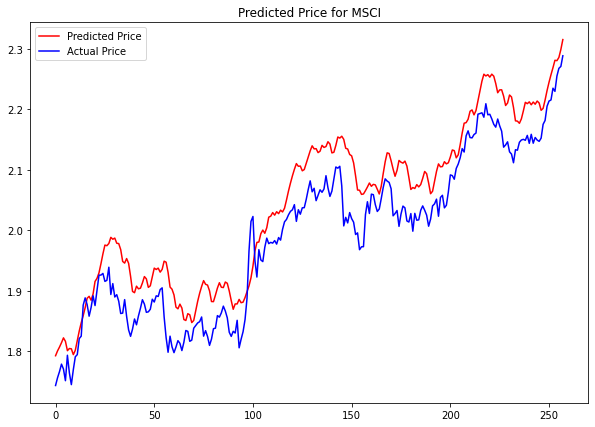

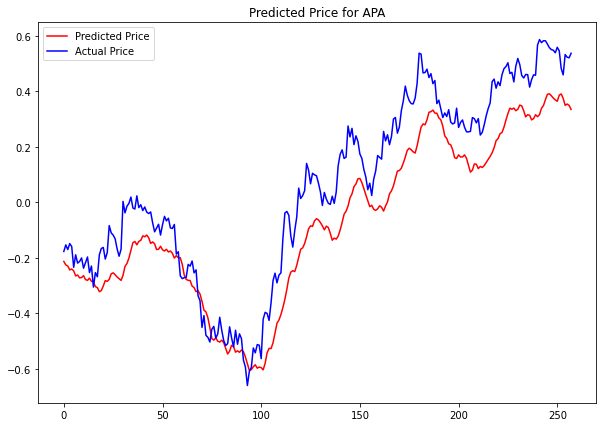

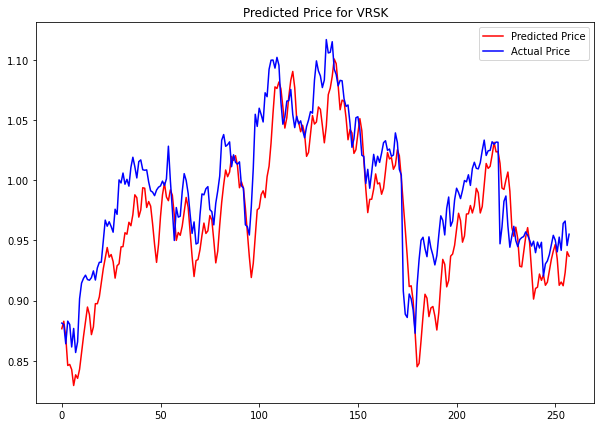

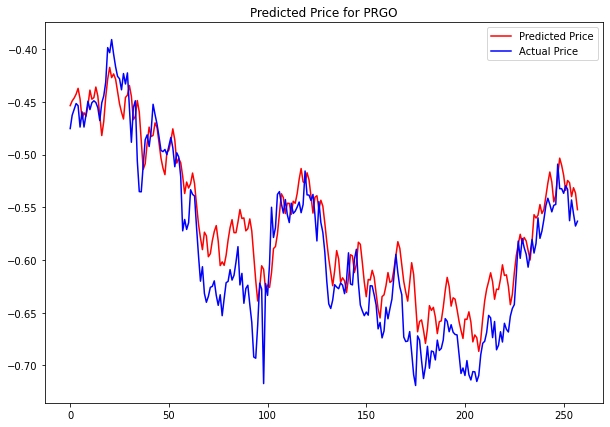

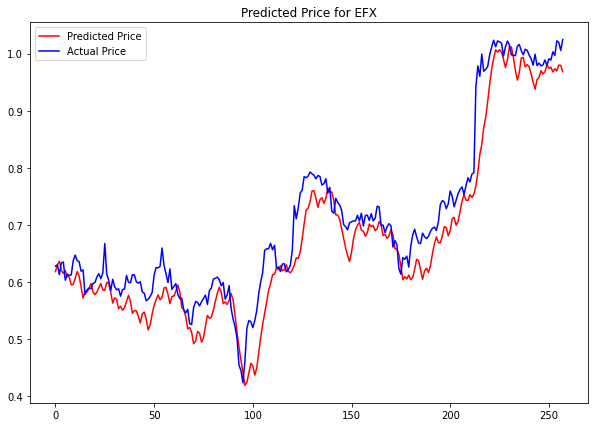

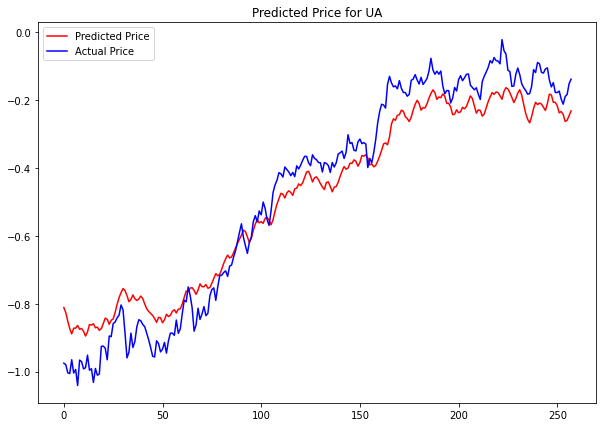

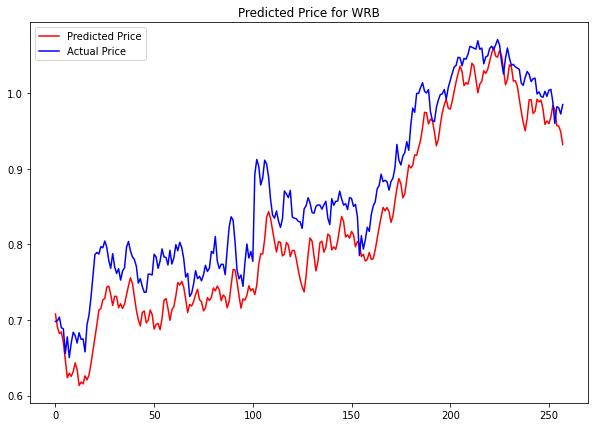

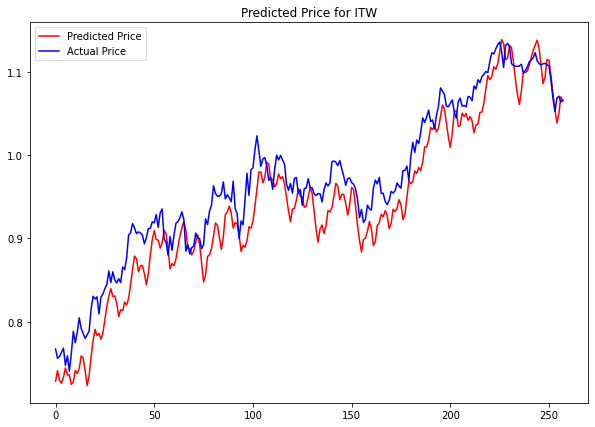

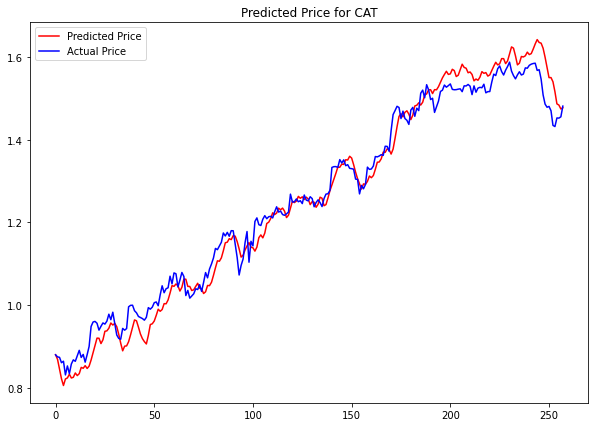

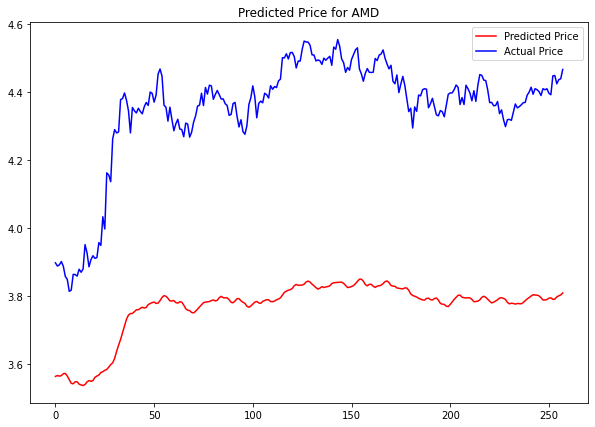

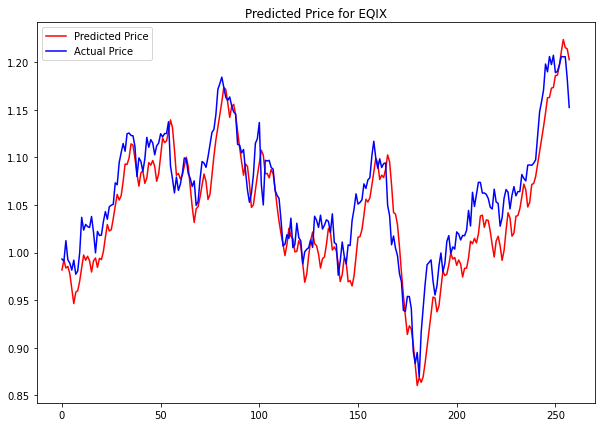

In [19]:
for idx in range(len(TICKER_LIST)):
    ticker = TICKER_LIST[idx]

    ticker_test = X_test[idx]

    ticker_yhat = model(ticker_test)
    ticker_yhat = scaler.inverse_transform(ticker_yhat.detach())
    ticker_y = y_test[idx]

    #Plot Predicted vs Acutal
    plt.figure(figsize=(10,7))
    plt.plot(ticker_yhat, c="red", label="Predicted Price")
    plt.plot(ticker_y, c="blue", label="Actual Price")
    plt.legend()
    plt.title(f"Predicted Price for {ticker}")
    plt.show()

